In [1]:
!pip install torch torchvision Pillow faiss-cpu tqdm langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00


In [2]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import faiss
from tqdm import tqdm
from langchain.embeddings.base import Embeddings
from langchain.schema.document import Document
from typing import List, Dict
import logging
from matplotlib import pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ImageEmbeddingModel:
    def __init__(self):
        # Load pre-trained ResNet model
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        # Remove the final classification layer
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])

        # Move to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

        # Define image transformations
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def get_embedding(self, image_path: str) -> np.ndarray:
        """Generate embedding for a single image."""
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image).unsqueeze(0).to(self.device)

            with torch.no_grad():
                embedding = self.model(image)

            # Flatten and convert to numpy array
            return embedding.cpu().numpy().flatten()
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None




In [3]:
class ImageSearchSystem:
    def __init__(self):
        self.embedding_model = ImageEmbeddingModel()
        self.image_paths: List[str] = []
        self.embeddings = None
        self.index = None
        self.image_to_metadata: Dict[str, dict] = {}

    def add_images(self, image_directory: str, batch_size: int = 32):
        """Process all images in a directory and build the FAISS index."""
        logger.info("Starting image processing...")

        # Get all image paths
        image_files = [
            os.path.join(image_directory, f) for f in os.listdir(image_directory)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
        ]

        embeddings_list = []
        valid_paths = []

        # Process images in batches
        for i in tqdm(range(0, len(image_files), batch_size)):
            batch_files = image_files[i:i + batch_size]

            for image_path in batch_files:
                embedding = self.embedding_model.get_embedding(image_path)

                if embedding is not None:
                    embeddings_list.append(embedding)
                    valid_paths.append(image_path)

                    # Store metadata
                    self.image_to_metadata[image_path] = {
                        'filename': os.path.basename(image_path),
                        'path': image_path,
                    }

        # Convert list of embeddings to numpy array
        self.embeddings = np.vstack(embeddings_list)
        self.image_paths = valid_paths

        # Build FAISS index
        self._build_faiss_index()

        logger.info(f"Processed {len(valid_paths)} images successfully")

    def _build_faiss_index(self):
        """Build FAISS index for fast similarity search."""
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner product index for cosine similarity

        # Normalize vectors to use inner product as cosine similarity
        faiss.normalize_L2(self.embeddings)
        self.index.add(self.embeddings)

        logger.info("FAISS index built successfully")

    def search(self, query_image_path: str, k: int = 5) -> List[Dict]:
        """Search for similar images given a query image."""
        # Get embedding for query image
        query_embedding = self.embedding_model.get_embedding(query_image_path)

        if query_embedding is None:
            raise ValueError("Could not process query image")

        # Reshape and normalize query embedding
        query_embedding = query_embedding.reshape(1, -1)
        faiss.normalize_L2(query_embedding)

        # Perform search
        distances, indices = self.index.search(query_embedding, k)

        # Prepare results
        results = []
        for distance, idx in zip(distances[0], indices[0]):
            if idx < len(self.image_paths):
                image_path = self.image_paths[idx]
                result = {
                    **self.image_to_metadata[image_path],
                    'similarity_score': float(distance)
                }
                results.append(result)

        return results

In [4]:
def visualize_results(query_image_path: str, results: List[Dict], figsize=(15, 8)):
    """Visualize query image and search results in a grid."""
    n_results = len(results)
    fig = plt.figure(figsize=figsize)

    # Create a grid with 2 rows: query image on top, results on bottom
    gs = plt.GridSpec(2, max(n_results, 1))

    # Plot query image
    ax = fig.add_subplot(gs[0, :])
    query_img = Image.open(query_image_path)
    ax.imshow(query_img)
    ax.set_title("Query Image", fontsize=12, pad=10)
    ax.axis('off')

    # Plot results
    for idx, result in enumerate(results):
        ax = fig.add_subplot(gs[1, idx])
        img = Image.open(result['path'])
        ax.imshow(img)
        ax.set_title(f"Score: {result['similarity_score']:.3f}\n{result['filename']}",
                    fontsize=10, pad=5)
        ax.axis('off')

    plt.tight_layout()
    return fig

100%|██████████| 9/9 [00:13<00:00,  1.50s/it]



Result 1:
Image: 382017.jpg
Similarity Score: 1.0000
Path: /content/drive/MyDrive/CBIR_DataSet/obj_decoys/382017.jpg

Result 2:
Image: 612027.jpg
Similarity Score: 0.7118
Path: /content/drive/MyDrive/CBIR_DataSet/obj_decoys/612027.jpg

Result 3:
Image: 382034.jpg
Similarity Score: 0.7117
Path: /content/drive/MyDrive/CBIR_DataSet/obj_decoys/382034.jpg

Result 4:
Image: 612055.jpg
Similarity Score: 0.7088
Path: /content/drive/MyDrive/CBIR_DataSet/obj_decoys/612055.jpg

Result 5:
Image: 612026.jpg
Similarity Score: 0.7071
Path: /content/drive/MyDrive/CBIR_DataSet/obj_decoys/612026.jpg


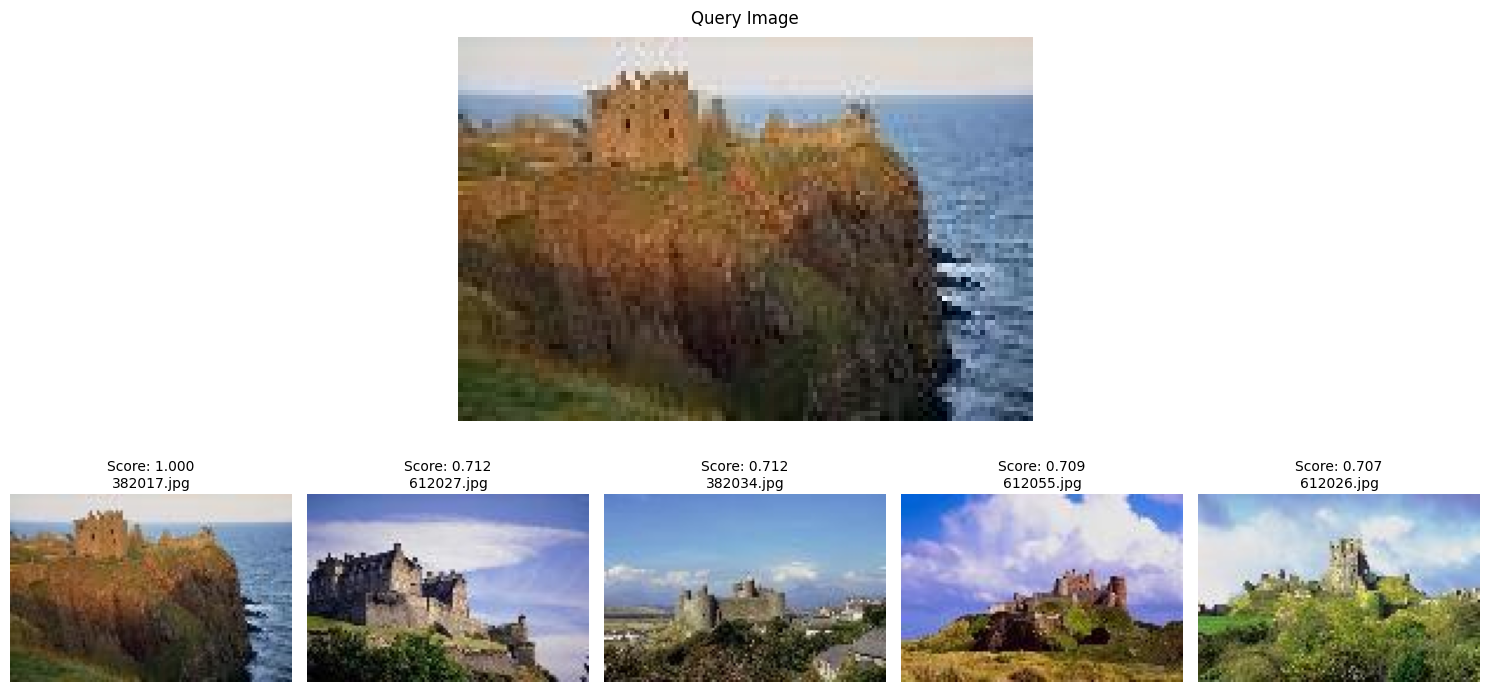

In [6]:
def main():
    # Initialize the search system
    search_system = ImageSearchSystem()

    # Add images to the system
    image_directory = "/content/drive/MyDrive/CBIR_DataSet/obj_decoys"
    search_system.add_images(image_directory)

    # Perform a search
    query_image = "/content/drive/MyDrive/CBIR_DataSet/img_requetes/ImageRequete.jpg"
    results = search_system.search(query_image, k=5)

    # Print results
    for i, result in enumerate(results, 1):
        print(f"\nResult {i}:")
        print(f"Image: {result['filename']}")
        print(f"Similarity Score: {result['similarity_score']:.4f}")
        print(f"Path: {result['path']}")

    # Visualize results
    fig = visualize_results(query_image, results)
    plt.show()

if __name__ == "__main__":
    main()